In [691]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.stats as si
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D

In [692]:
ADA = yf.download("ADA-USD", start="2021-03-31", end="2022-03-31")

[*********************100%***********************]  1 of 1 completed


In [693]:
ADA.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-27,1.151006,1.183395,1.108125,1.182148,1.182148,1322194562
2022-03-28,1.182334,1.242865,1.162468,1.170184,1.170184,2304056098
2022-03-29,1.169285,1.239358,1.169033,1.191112,1.191112,1761798381
2022-03-30,1.190980,1.216669,1.167608,1.190385,1.190385,1424442312
2022-03-31,1.190299,1.226320,1.137162,1.141851,1.141851,1745903089


In [694]:
ADA.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-31,1.213675,1.213675,1.167720,1.193264,1.193264,3190463749
2021-04-01,1.193553,1.207719,1.184130,1.189244,1.189244,2309789364
2021-04-02,1.189208,1.245915,1.187607,1.196509,1.196509,2909026267
2021-04-03,1.196326,1.244183,1.171635,1.173277,1.173277,3355350115
2021-04-04,1.172973,1.199748,1.166279,1.191420,1.191420,2166855014


In [695]:
ADA_price = ADA['Adj Close'][-1]
print('The spot price for ADA is $', round(ADA_price,2))

The spot price for ADA is $ 1.14


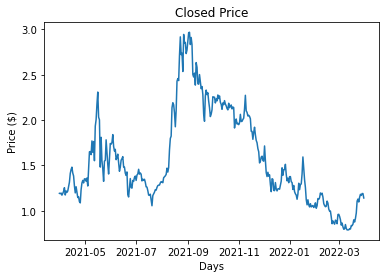

In [696]:
fig = plt.figure()
plt.plot(ADA['Close'])
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.title('Closed Price');

In [697]:
ADA_log_return = np.log(ADA['Adj Close'] / ADA['Adj Close'].shift(1))
ADA_vol = np.sqrt(365) * ADA_log_return.std()
print('The annulized log return is')
ADA_log_return


The annulized log return is


Date
2021-03-31         NaN
2021-04-01   -0.003375
2021-04-02    0.006090
2021-04-03   -0.019607
2021-04-04    0.015345
                ...   
2022-03-27    0.027055
2022-03-28   -0.010172
2022-03-29    0.017726
2022-03-30   -0.000611
2022-03-31   -0.041626
Name: Adj Close, Length: 366, dtype: float64

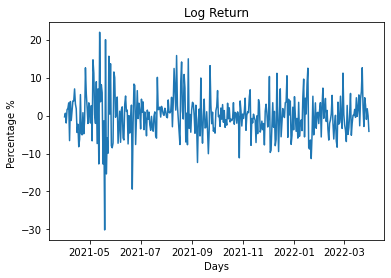

In [698]:
fig = plt.figure()
plt.plot(ADA_log_return * 100)
plt.xlabel('Days')
plt.ylabel('Percentage % ')
plt.title('Log Return');

In [713]:
print('The annualised volatility is', round(ADA_vol*100,2), '%')

The annualised volatility is 109.51 %


In [714]:
#Black Schole Model

In [715]:
def ADA_euro_option_bsm(S, K, T, r, ADA_vol, ADA_payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #ADA_vol: volatility of underlying asset
    #payoff: call or put
    d1 = (np.log(S / K) + (r + 0.5 * ADA_vol ** 2) * T) / (ADA_vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * ADA_vol ** 2) * T) / (ADA_vol * np.sqrt(T))
    if ADA_payoff == "call":
        ADA_ov = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif ADA_payoff == "put":
        ADA_ov = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return ADA_ov

In [716]:
#payoff: call
S = ADA['Adj Close'][-1]
K = 1.05
T = 1
r = 0.016
ADA_vol
ADA_bsm_call = ADA_euro_option_bsm(S, K, T, r, ADA_vol, 'call')
print("BSM European call option is: ${:.8}".format(ADA_bsm_call))

BSM European call option is: $0.50837854


In [717]:
#Monte Carlo Simulation

In [718]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - ADA_vol ** 2 / 2) * dt + ADA_vol * np.sqrt(dt) * rn[t]) 
    return S

In [719]:
S0 = ADA['Adj Close'][-1]
K = 1.05
T = 1
r = 0.016
ADA_vol
payoff = "call"

In [720]:
S = mcs_simulation_np(10000)
S = np.transpose(S)
S

array([[1.14185095, 1.1560655 , 1.15768821, ..., 0.14370899, 0.14329095,
        0.14329394],
       [1.14185095, 1.1262353 , 1.13864713, ..., 0.16617612, 0.16707302,
        0.17107373],
       [1.14185095, 1.14251184, 1.13815789, ..., 0.47494346, 0.47617998,
        0.46784405],
       ...,
       [1.14185095, 1.15509738, 1.15831325, ..., 0.42944388, 0.43086229,
        0.43063353],
       [1.14185095, 1.16595676, 1.14158457, ..., 1.39922272, 1.4077918 ,
        1.37314162],
       [1.14185095, 1.14227029, 1.12951991, ..., 0.74637436, 0.75780441,
        0.76408958]])

In [722]:
ADA_mcs_call = np.mean(np.maximum(S[:,-1] - K,0))
print("Monte Carlo Simulation European Call option is: ${:.8}".format(ADA_mcs_call))

Monte Carlo Simulation European Call option is: $0.51130907


In [723]:
#Greeks

In [724]:
#Delta

In [725]:
def delta(S, K, T, r, q, ADA_vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * ADA_vol ** 2) * T) / (ADA_vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [726]:

S = ADA['Adj Close'][-1]
K = 1.05
T = 1
r = 0.016
q = 0
ADA_vol
delta(S, K, T, r, q, ADA_vol, 'call')
print('The value of Delta is', d.round(4),'.','If the stock price increase $1, then the value of the option will increase $', d.round(4), '.')

The value of Delta is 0.7815 . If the stock price increase $1, then the value of the option will increase $ 0.7815 .


In [727]:
S = np.linspace(0.5,2.5,5)
Delta_Call = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], K, T, r, q, ADA_vol, 'call')

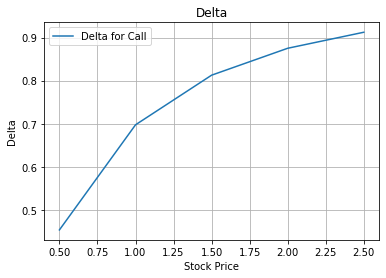

In [728]:
#2D Figure
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call'])

In [729]:
#3D Figure
#Surface of Delta

S = np.linspace(0.5,2.5,5)
T = np.linspace(0.1, 0.5, 51)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], K, T[i], r, q, ADA_vol, 'call')

/var/folders/n6/401l90_d2xj1_4w727k3nvzc0000gp/T/ipykernel_2150/1013132502.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


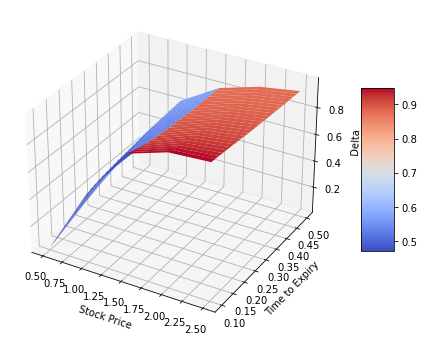

In [730]:
 fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [731]:
#Gamma

In [732]:
def gamma(S, K, T, r, q, ADA_vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * ADA_vol ** 2) * T) / (ADA_vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (ADA_vol * S * np.sqrt(T))
    
    return gamma

In [733]:
S = ADA['Adj Close'][-1]
K = 1.05
T = 1
r = 0.016
q = 0
ADA_vol
gamma(S, K, T, r, q, ADA_vol, 'call')

0.2601802984557987

In [734]:
S = np.linspace(0.5,2.5,5)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], K, T, r, q, ADA_vol, 'call')

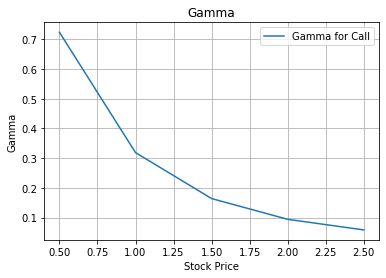

In [735]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call'])

In [736]:
#Surface of Gamma
S = np.linspace(0.5,2.5,5)
T = np.linspace(0.1, 0.5, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], K, T[i], r, q, ADA_vol, 'call')

/var/folders/n6/401l90_d2xj1_4w727k3nvzc0000gp/T/ipykernel_2150/3848859912.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


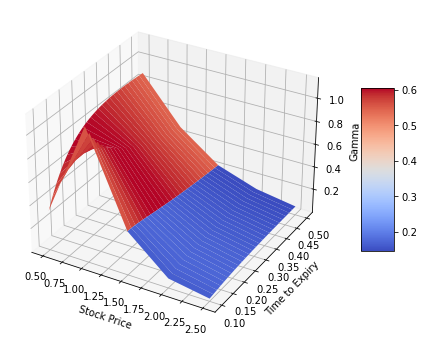

In [737]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [738]:
#Speed

In [739]:
def speed(S, K, T, r, q, ADA_vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (ADA_vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((ADA_vol **2) * (S**2) * np.sqrt(T)) * (d1 + ADA_vol * np.sqrt(T))
    
    return speed

In [740]:
S = ADA['Adj Close'][-1]
K = 1.05
T = 1
r = 0.016
q = 0
ADA_vol
speed(S, K, T, r, q, ADA_vol, 'call')

-0.3505155076883493

In [741]:

S = np.linspace(0.5,2.5,5)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], K, T, r, q, ADA_vol, 'call')

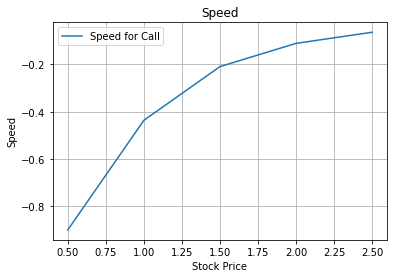

In [742]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call'])

In [743]:
#Surface of Speed
S = np.linspace(0.5,2.5,5)
T = np.linspace(0.1, 0.5, 51)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], K, T[i], r, q, ADA_vol, 'call')

/var/folders/n6/401l90_d2xj1_4w727k3nvzc0000gp/T/ipykernel_2150/1603304871.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


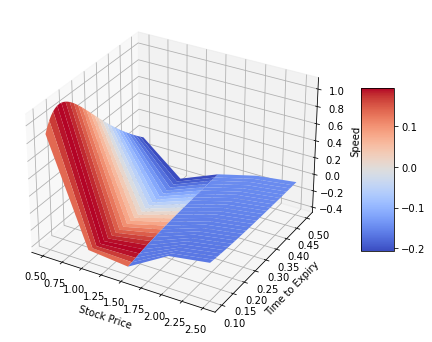

In [744]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [745]:
#Theta

In [746]:
def theta(S, K, T, r, q, ADA_vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * ADA_vol ** 2) * T) / (ADA_vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * ADA_vol ** 2) * T) / (ADA_vol * np.sqrt(T))
    if payoff == "call":
        theta = ADA_vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = ADA_vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [747]:
S = ADA['Adj Close'][-1]
K = 1.05
T = 1
r = 0.016
q = 0
ADA_vol
theta(S, K, T, r, q, ADA_vol, 'call')

0.20875227756255793

In [748]:
T = np.linspace(0.5,2.5,5)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(S, K, T[i], r, q, ADA_vol, 'call')

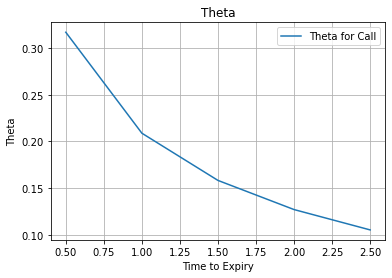

In [749]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call'])

In [750]:
#Surface of Theta
S = np.linspace(0.5,2.5,5)
T = np.linspace(0.1, 0.5, 51)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], K, T[i], r, q, ADA_vol, 'call')


/var/folders/n6/401l90_d2xj1_4w727k3nvzc0000gp/T/ipykernel_2150/383283098.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


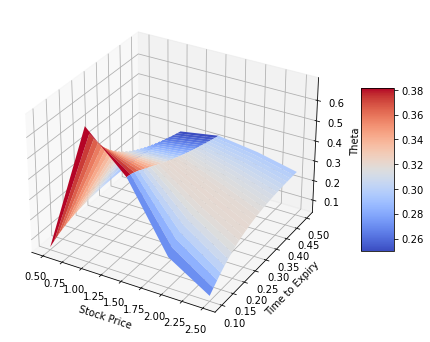

In [751]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [752]:
#Vega

In [753]:
def vega(S, K, T, r, q, ADA_vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * ADA_vol ** 2) * T) / (ADA_vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [754]:
S = ADA['Adj Close'][-1]
K = 1.05
T = 1
r = 0.016
q = 0
ADA_vol
vega(S, K, T, r, q, ADA_vol, 'call')

0.3714761755873591

In [755]:
ADA_vol = np.linspace(0.5,2.5,5)
Vega = np.zeros((len(ADA_vol),1))
for i in range(len(ADA_vol)):
    Vega [i] = vega(S, K, T, r, q, ADA_vol[i],'call')

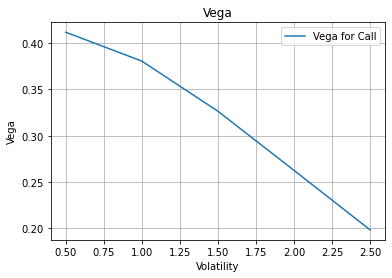

In [756]:
fig = plt.figure()
plt.plot(ADA_vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call'])

In [757]:
#Surface of Vega


S = np.linspace(0.5,2.5,5)
T = np.linspace(0.1, 0.5, 51)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 1.05, T[i], 0.016, 0, 1.09, 'call')
        
        



#
#S = np.linspace(0.1,0.3,25)
#T = np.linspace(0.1, 0.5, 51)
#Vega = np.zeros((len(T),len(S)))
#for j in range(len(S)):
#    for i in range(len(T)):
#        Vega[i,j] = vega(S[j], K, T[i], r, q, ADA_vol, 'call')

/var/folders/n6/401l90_d2xj1_4w727k3nvzc0000gp/T/ipykernel_2150/2704700163.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


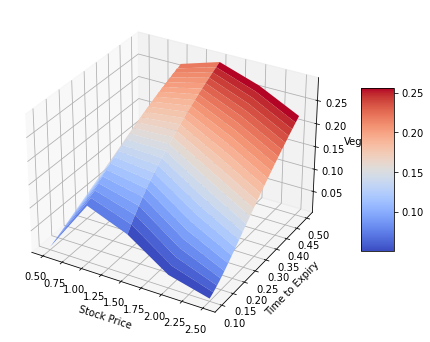

In [758]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);